In [5]:
!pip install osmnx

In [6]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import networkx as nx

# The area of interest...
#Best to look for a city where streets network is well coded
#Maybe you'll get to test different streets networks in different cities
#OSM, Open Street Map Server provide enough data to fullfill your needs

query ="Mahdia, Tunisia"

# Using test data
G = ox.graph_from_place(query, network_type="drive", simplify=False)

type(G)

networkx.classes.multidigraph.MultiDiGraph

In [7]:
#Check if the streets graph is well defined e.g. number of ways, maxspeed,class: highway?
#extract nodes and edges from G, the street graph

In [8]:
nodes, edges = ox.graph_to_gdfs(G)
edges.head()

osmid        highway lanes  oneway  reversed  \
u         v          key                                                     
313671520 9857882474 0    173655525  motorway_link     2   False     False   
          1844242194 0    173655525  motorway_link     2   False      True   
314599433 314599437  0     43943677       motorway     2    True     False   
314599437 8987462751 0     28619699  motorway_link     2    True     False   
          6602488112 0     43943677       motorway     2    True     False   

                              length maxspeed  \
u         v          key                        
313671520 9857882474 0     56.718351      NaN   
          1844242194 0     22.452789      NaN   
314599433 314599437  0    101.166066      110   
314599437 8987462751 0     35.129958      NaN   
          6602488112 0     60.993986      110   

                                                        name  ref bridge  \
u         v          key                                                   
313671520 9857882474 0                                   NaN  NaN    NaN   
          1844242194 0                                   NaN  NaN    NaN   
314599433 314599437  0    الطريق السريعة تونس - سوسة - صفاقس   A1    NaN   
314599437 8987462751 0                                   NaN  NaN    NaN   
          6602488112 0    الطريق السريعة تونس - سوسة - صفاقس   A1    NaN   

                         junction tunnel width access  \
u         v          key                                
313671520 9857882474 0        NaN    NaN   NaN    NaN   
          1844242194 0        NaN    NaN   NaN    NaN   
314599433 314599437  0        NaN    NaN   NaN    NaN   
314599437 8987462751 0        NaN    NaN   NaN    NaN   
          6602488112 0        NaN    NaN   NaN    NaN   

                                                                   geometry  
u         v          key                                                     
313671520 9857882474 0    LINESTRING (10.65496 35.30938, 10.65434 35.30943)  
          1844242194 0    LINESTRING (10.65496 35.30938, 10.65521 35.30935)  
314599433 314599437  0    LINESTRING (10.65298 35.31379, 10.65289 35.31288)  
314599437 8987462751 0    LINESTRING (10.65289 35.31288, 10.65277 35.31258)  
          6602488112 0    LINESTRING (10.65289 35.31288, 10.65283 35.31234)

In [ ]:
#display the graph streets network with its properties

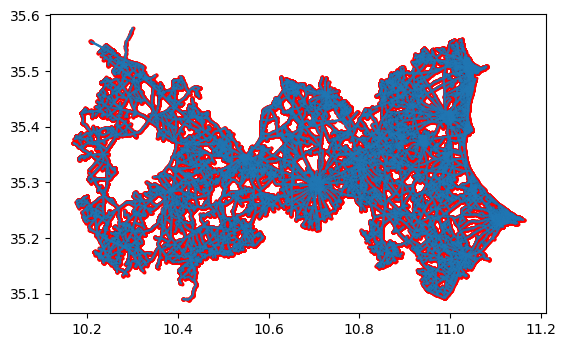

In [9]:
ax = edges.plot()
ax = nodes.plot(ax=ax, color="red", markersize=3.5)

In [10]:
edges["oneway"].unique()

array([False,  True])

In [11]:
edges["maxspeed"].unique()

array([nan, '110', '50', '90', '30', '20', '70'], dtype=object)

In [12]:
edges["highway"].unique()

array(['motorway_link', 'motorway', 'primary', 'unclassified',
       'residential', 'secondary', 'tertiary', 'primary_link',
       'tertiary_link', 'secondary_link'], dtype=object)

In [13]:
nodes.head()

,y,x,street_count,highway,ref,railway,geometry
osmid,,,,,,,
313671520,35.309377,10.654964,2,NaN,NaN,NaN,POINT (10.65496 35.30938)
314599433,35.313791,10.652982,2,NaN,NaN,NaN,POINT (10.65298 35.31379)
314599437,35.312885,10.652886,3,motorway_junction,19,NaN,POINT (10.65289 35.31288)
314599441,35.309589,10.652191,2,NaN,NaN,NaN,POINT (10.65219 35.30959)
314599443,35.309689,10.651505,2,NaN,NaN,NaN,POINT (10.65151 35.30969)


In [14]:
#the network distance is not the best cost metric to use,
#because the shortest path (based on distance) is not necessarily
#always the optimal route in terms of travel time.
#Adjust converts the metric distance information to
#travel time (in seconds) based on following formula:
#<distance-in-meters> / (<speed-limit-kmph> / 3.6)

In [15]:
#Finding the segmants with NaN speed value using dropna parameter

In [16]:
edges["maxspeed"].value_counts(dropna=False)

,count
maxspeed,
NaN,614916
50,3025
90,2842
110,763
30,728
70,249
20,32


In [17]:
#Above NaN = 36

In [18]:
#Prepare dataframe, change data type maxspeed to integer

In [19]:
edges["maxspeed"] = edges["maxspeed"].astype(float).astype(pd.Int64Dtype())
edges["maxspeed"].unique()

<IntegerArray>
[<NA>, 110, 50, 90, 30, 20, 70]
Length: 7, dtype: Int64

In [20]:
#function that returns a numeric value for different road classes
#Check the properties of the streets network u used and adjust the function accordingly

def road_class_to_kmph(road_class):
    """
    Returns a speed limit value based on road class,
    using typical Finnish speed limit values within urban regions.
    """
    if road_class == "motorway":
        return 100
    elif road_class == "motorway_link":
        return 80
    elif road_class in ["trunk", "trunk_link"]:
        return 60
    elif road_class == "service":
        return 30
    elif road_class == "living_street":
        return 20
    else:
        return 50

In [21]:
#Call the function
mask = edges["maxspeed"].isnull()

In [22]:
mask

u            v            key
313671520    9857882474   0       True
             1844242194   0       True
314599433    314599437    0      False
314599437    8987462751   0       True
             6602488112   0      False
                                 ...  
12232445433  12232445434  0       True
12232445434  12232445433  0       True
             4462490888   0       True
12389113052  6683497101   0       True
             2278716949   0       True
Name: maxspeed, Length: 622555, dtype: bool

In [23]:
# Separate rows with / without speed limit information
mask = edges["maxspeed"].isnull()
edges_without_maxspeed = edges.loc[mask].copy()
edges_with_maxspeed = edges.loc[~mask].copy()

# Apply the function and update the maxspeed and visualize the results
edges_without_maxspeed["maxspeed"] = edges_without_maxspeed["highway"].apply(road_class_to_kmph)
edges_without_maxspeed.head(5).loc[:, ["maxspeed", "highway"]]

maxspeed        highway
u         v          key                         
313671520 9857882474 0          80  motorway_link
          1844242194 0          80  motorway_link
314599437 8987462751 0          80  motorway_link
314599441 1844242204 0          80  motorway_link
          1844242201 0          80  motorway_link

In [24]:
#recreate the edges GeoDataFrame by combining the two frames
#edges_without_maxspeed = edges.loc[mask].copy()
#edges_with_maxspeed = edges.loc[~mask].copy()
edges = pd.concat([edges_with_maxspeed, edges_without_maxspeed])
edges["maxspeed"].unique()

<IntegerArray>
[110, 50, 90, 30, 20, 70, 80]
Length: 7, dtype: Int64

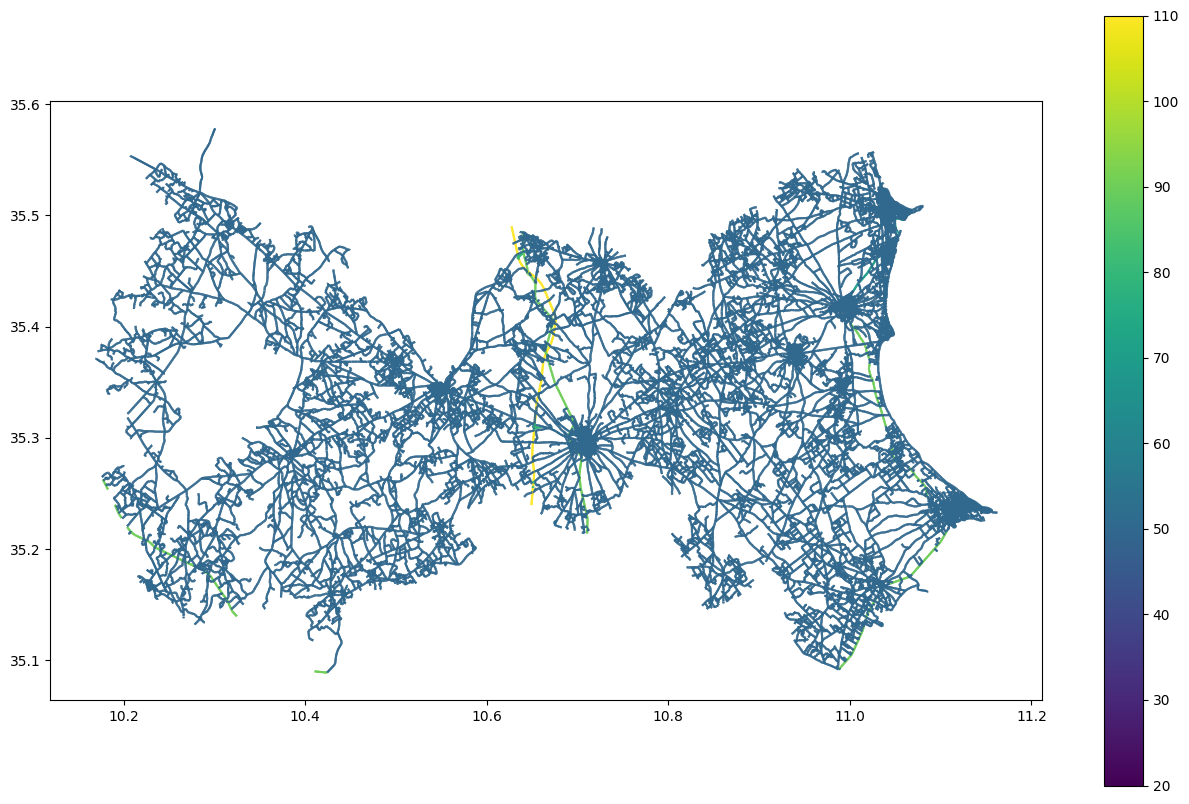

In [25]:
# Convert the value into regular integer Series (the plotting requires having Series instead of IntegerArray)
edges["maxspeed"] = edges["maxspeed"].astype(int)
ax = edges.plot(column="maxspeed", figsize=(16,10), legend=True)

In [26]:
#calculate the travel time in seconds using the formula we saw earlier
#and add that as a new cost attribute for our network
edges["travel_time_seconds"] = edges["length"] / (edges["maxspeed"]/3.6)
edges.iloc[0:10, -4:]

,,,width,access,geometry,travel_time_seconds
u,v,key,,,,
314599433,314599437,0,NaN,NaN,"LINESTRING (10.65298 35.31379, 10.65289 35.31288)",3.310889
314599437,6602488112,0,NaN,NaN,"LINESTRING (10.65289 35.31288, 10.65283 35.31234)",1.996167
314599455,6673186405,0,NaN,NaN,"LINESTRING (10.65248 35.30935, 10.65237 35.30835)",3.638834
314599930,6673171851,0,NaN,NaN,"LINESTRING (10.65481 35.33014, 10.65468 35.32914)",3.672226
314599937,6673058221,0,NaN,NaN,"LINESTRING (10.65983 35.35001, 10.6596 35.34894)",3.956315
314599940,6673058213,0,NaN,NaN,"LINESTRING (10.66049 35.35421, 10.66041 35.35351)",2.550922
314599945,6673038244,0,NaN,NaN,"LINESTRING (10.66209 35.36719, 10.66199 35.36671)",1.765519
314599948,9860064845,0,NaN,NaN,"LINESTRING (10.66348 35.37217, 10.66327 35.37163)",2.077206
314599950,6673038277,0,NaN,NaN,"LINESTRING (10.66433 35.37417, 10.66413 35.37373)",1.703379


In [27]:
#Built a directed graph with osmnx

In [28]:
G = ox.graph_from_gdfs(gdf_nodes=nodes, gdf_edges=edges)
G

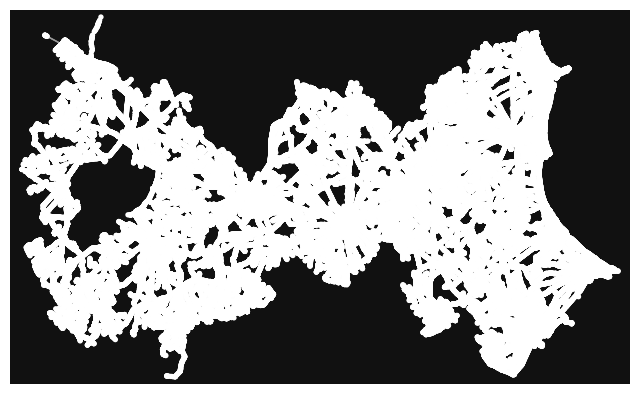

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [29]:
import osmnx as ox
ox.plot_graph(G)

In [30]:
# Algorithme de plus court chemin (Dijkstra)

import osmnx as ox

# Adresse d'origine à Mahdia
orig_address = "Chebba, Mahdia, Tunisia"
orig_y, orig_x = ox.geocode(orig_address)

# Adresse de destination à Mahdia
dest_address = "Ksour Essef, Mahdia, Tunisia"
dest_y, dest_x = ox.geocode(dest_address)

print("Coordonnées de départ :", orig_x, orig_y)
print("Coordonnées de destination :", dest_x, dest_y)


Coordonnées de départ : 11.1129606 35.2365755
Coordonnées de destination : 10.9987172 35.4162835


In [31]:
# Find the closest nodes for origin and destination
orig_node_id, dist_to_orig = ox.distance.nearest_nodes(G, X=orig_x, Y=orig_y, return_dist=True)
dest_node_id, dist_to_dest = ox.distance.nearest_nodes(G, X=dest_x, Y=dest_y, return_dist=True)

print("Origin node-id:", orig_node_id, "and distance:", dist_to_orig, "meters.")
print("Destination node-id:", dest_node_id, "and distance:", dist_to_dest, "meters.")

Origin node-id: 443160073 and distance: 36.08262451486954 meters.
Destination node-id: 2232263429 and distance: 6.068717921760834 meters.


In [32]:
# Calculate the paths
metric_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='length')
time_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

# Get also the actual travel times (summarize)
travel_length = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='length')
travel_time = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

In [33]:
metric_path == time_path

False

In [34]:
travel_length

24229.146154588143

In [35]:
travel_time

1286.5918742813813

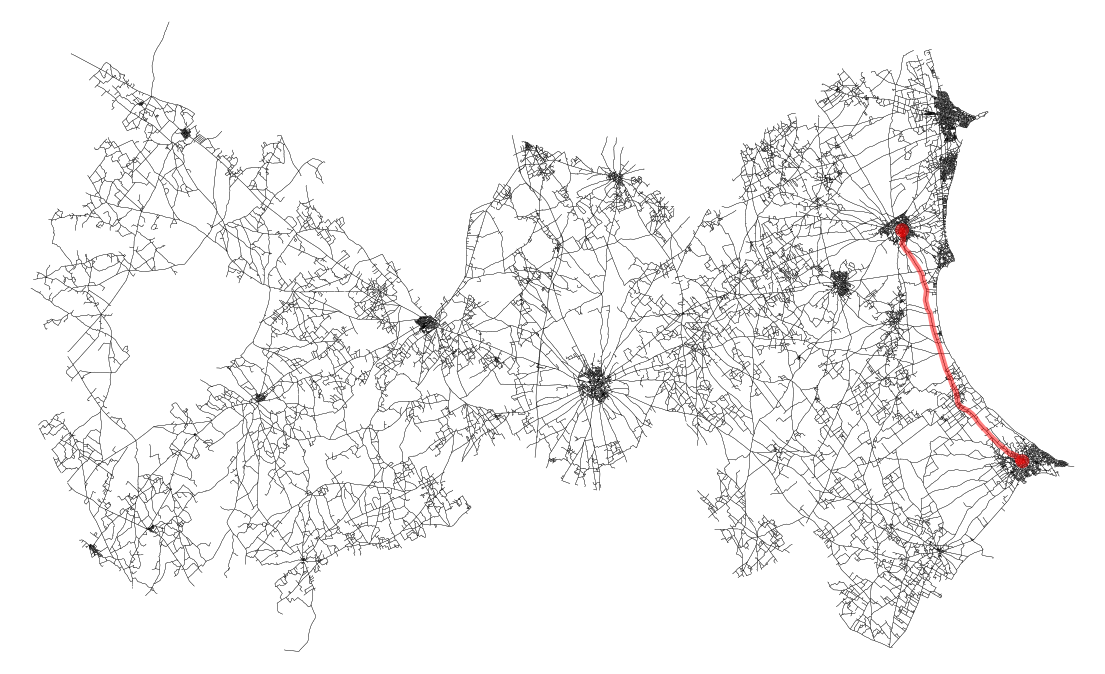

Shortest path distance  24229.1 meters.


In [36]:
# Shortest path based on distance
fig, ax = ox.plot_graph_route(G, metric_path,
                              edge_linewidth=0.2, node_size=0, bgcolor="white", edge_color="black", figsize=(14,10))

# Print some useful information as well
print(f"Shortest path distance {travel_length: .1f} meters.")

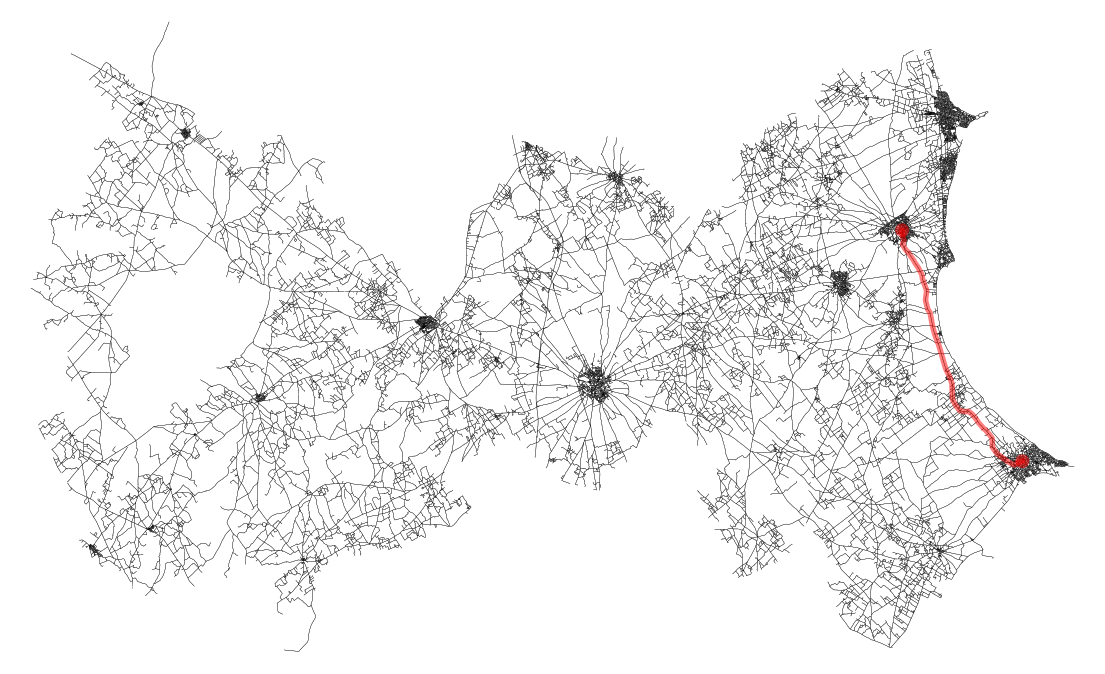

Shortest path time  21.4 minutes.


In [37]:
fig, ax = ox.plot_graph_route(G, time_path,
                             edge_linewidth=0.2, node_size=0, bgcolor="white", edge_color="black", figsize=(14,10))

# Print some useful information as well
print(f"Shortest path time {travel_time/60: .1f} minutes.")